In [14]:
import os
import numpy as np
import matplotlib.pylab as plt

In [15]:
import sys
sys.path.append('../')
from utils import step_schedule_exp_decay as exp_decay_imported
from helpers import save_dict,load_dict
from plotting_helpers import add_gridlines, add_energy_legends

In [16]:
from scipy.optimize import curve_fit

In [17]:
import os
os.environ["PATH"] += ":/usr/local/texlive/2024/bin/universal-darwin"


plt.rcParams.update({
    "text.usetex": True,
    "font.size": 15,
    "font.family": "Helvetica"
})

column_width = 3.75
square_fig_size=(2*column_width,3/2*column_width)
bigger_font_size=22


## Helper Functions

In [18]:
def fourth_order(x, c1, c2, c3, c4, cy):
    return cy + c1 * x + c2 * x**2 + c3 * x**3 + c4 * x**4
def fourth_order_only(x, c4, cy):
    return cy + c4 * x**4

# Load Data

In [19]:
scales = [1.,2.,4.]
rates = [0.158,0.25,0.475]

Ls_all = np.arange(6,31,6)

In [20]:
run_times = load_dict('./plotting_data/runtimes_data.pkl')

In [21]:
rate_markers={0.158:'*',0.25:'H',0.475:'^'}
rate_lines={0.158:':',0.25:'--',0.475:'-'}
rate_alphas={0.475:0.2,0.25:0.5,0.158:0.9}

colorscale_sq = plt.get_cmap('viridis')
colorscale_tri = plt.get_cmap('plasma')
shades = np.linspace(0.,0.9,2*len(scales))[::-2]
colors_sq = colorscale_sq(shades)
colors_tri = colorscale_tri(shades)
scale_shades = {'Square':{1.0:colors_sq[0],2.0:colors_sq[1],4.0:colors_sq[2]},
                'Triangular':{1.0:colors_tri[0],2.0:colors_tri[1],4.0:colors_tri[2]}}

# Number of training steps

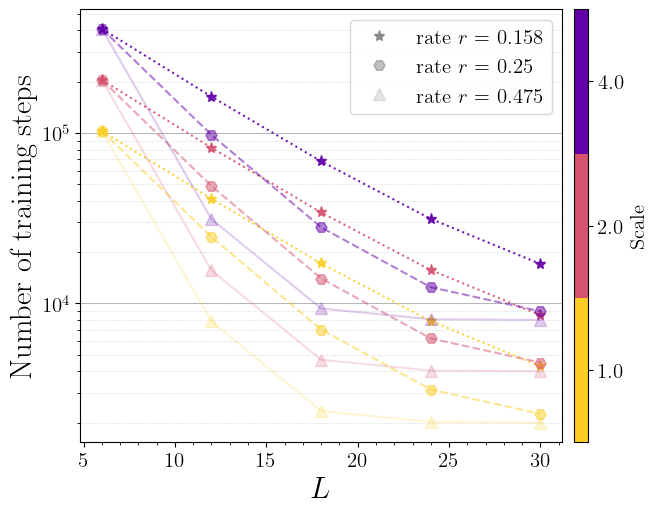

In [22]:
fig, ax = plt.subplots(figsize=square_fig_size)
ms = 'Triangular'

for rate_i,rate in enumerate(rates[:]):
    for scale_i,scale in enumerate(scales):
        if (scale==8.0) & (rate==0.158):
            continue
        plot_Ls = []
        steps_per_L = []
        for L_i,L in enumerate(Ls_all):
            plot_Ls.append(L)
            steps = exp_decay_imported(L,scale=scale,rate=rate)
            steps_rounded = int(np.floor(steps/100)*100)
            steps_per_L.append(steps)

            total_steps = np.sum(np.array(steps_per_L))
            # print(f"{scale},{rate},{L}: {total_steps}")
        
        if scale_i==0:
            plt.errorbar(plot_Ls,steps_per_L,c=scale_shades[ms][scale],
                         alpha=rate_alphas[rate],
                        markersize=8,marker=rate_markers[rate],linestyle=rate_lines[rate],
                        label=f'rate={rate}')
        else:
            plt.errorbar(plot_Ls,steps_per_L,color=scale_shades[ms][scale],
                         alpha=rate_alphas[rate],
                        markersize=8,marker=rate_markers[rate],linestyle=rate_lines[rate])

add_gridlines(axes='y')
add_energy_legends(show_runs=True)

plt.ylabel("Number of training steps",fontsize=bigger_font_size)
plt.xlabel("$L$",fontsize=bigger_font_size)
plt.yscale('log')

plt.savefig('./final_figures/num_training_steps.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

# Time per step

In [23]:
which_bc = 'periodic'
rate = 0.475
scale = 1.0
plot_ls = []
plot_times = []
open_plot_times = []

for l_i, key in enumerate(run_times.keys()):
    print(key)
    if l_i>=5:
        continue
    if 'mean time per step' in run_times[key].keys():
        plot_ls.append(Ls_all[l_i])
        plot_times.append(run_times[key]['mean time per step'])
        print(f"For {key}, run time = {run_times[key]['mean time per step']}")

print(plot_ls)

L=6
For L=6, run time = 0.2776134095354405
L=12
For L=12, run time = 3.662018906855153
L=18
For L=18, run time = 18.18860294154746
L=24
For L=24, run time = 57.72434663103673
L=30
For L=30, run time = 137.4104113349456
L=36
[6, 12, 18, 24, 30]


4th order only
coeff for fourth order: 0.00016965927412155337
intercept:              0.40040439990597626
full fit
coeff for first order:  1.573232372548725
coeff for second order:  -0.1788253424684874
coeff for third order:  0.008241921691302962
coeff for fourth order: 4.096515696367938e-05
intercept:              -4.55741442563773


/Users/megan/miniconda3/envs/HeisenbergRNN/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


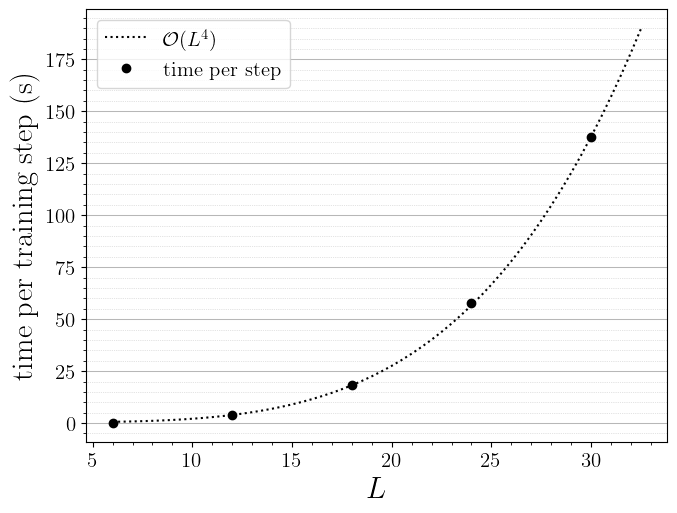

In [24]:
fig,ax = plt.subplots(figsize=square_fig_size)

plot_ls_np = np.array(plot_ls)
plot_times_np = np.array(plot_times)

plt.errorbar(plot_ls_np,plot_times_np,label='time per step',color='k',fmt='o')

params, covariance = curve_fit(fourth_order, plot_ls_np, plot_times_np)
params_4only, covariance = curve_fit(fourth_order_only, plot_ls_np, plot_times_np)
x_mesh = np.arange(min(plot_ls_np),1.1*max(plot_ls_np),0.5)
# plt.plot(x_mesh,fourth_order(x_mesh,params[0],params[1],params[2],params[3],params[4]),color='k',linestyle='--',label='full')
plt.plot(x_mesh,fourth_order_only(x_mesh,params_4only[0],params_4only[1]),color='k',linestyle=':',label='$\mathcal{O}(L^4)$')

print("4th order only")
print(f"coeff for fourth order: {params_4only[0]}")
print(f"intercept:              {params_4only[1]}")
print("full fit")
print(f"coeff for first order:  {params[0]}")
print(f"coeff for second order:  {params[1]}")
print(f"coeff for third order:  {params[2]}")
print(f"coeff for fourth order: {params[3]}")
print(f"intercept:              {params[4]}")

add_gridlines(axes='y')

plt.xlabel("$L$",fontsize=bigger_font_size)
plt.ylabel("time per training step (s)",fontsize=bigger_font_size)
plt.legend()

plt.savefig('./final_figures/time_per_L.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()

# Run times

In [25]:
ngpus = 5
for scale_i,scale in enumerate(scales):
    for rate in rates[:]:
        print(f"\nScale = {scale}, Rate = {rate}\n","--"*50)
        if (scale==8.0) & (rate==0.158):
            continue
        decay = np.array([exp_decay_imported(l,scale=scale,rate=rate) for l in plot_ls_np])
        decay_runtimes = []
        run_time_remaining = 0
        for l_i,l in enumerate(plot_ls_np):
            print(f"L = {l}")
            num_new_steps = decay[l_i] 
            new_run_time = num_new_steps * plot_times[l_i]
            gpu_days = new_run_time/(60*60*24)
            if (l > 18):
                run_time_remaining += gpu_days
            if rate == 0.158:
                print(gpu_days," GPU days")
                print(f"{gpu_days/ngpus} days for {ngpus} GPUs")
        if rate ==0.158:
            print("--"*50)
            print(f"Run time remaining = {run_time_remaining}")
            print(f"Run time remaining for {ngpus} gpus = {run_time_remaining/ngpus}")
            print("--"*50)



Scale = 1.0, Rate = 0.158
 ----------------------------------------------------------------------------------------------------
L = 6
0.3309511710897034  GPU days
0.06619023421794068 days for 5 GPUs
L = 12
1.7436550440869694  GPU days
0.3487310088173939 days for 5 GPUs
L = 18
3.6137217372060615  GPU days
0.7227443474412123 days for 5 GPUs
L = 24
5.262669889035606  GPU days
1.0525339778071212 days for 5 GPUs
L = 30
6.802133440735675  GPU days
1.360426688147135 days for 5 GPUs
----------------------------------------------------------------------------------------------------
Run time remaining = 12.06480332977128
Run time remaining for 5 gpus = 2.412960665954256
----------------------------------------------------------------------------------------------------

Scale = 1.0, Rate = 0.25
 ----------------------------------------------------------------------------------------------------
L = 6
L = 12
L = 18
L = 24
L = 30

Scale = 1.0, Rate = 0.475
 --------------------------------------

- scale=1,rate=0.158: 3.19 days 4 gpus
- scale=2,rate=0.158: 6.013 days 4 gpus
- scale=4,rate=0.158: 12.359 days 4 gpus

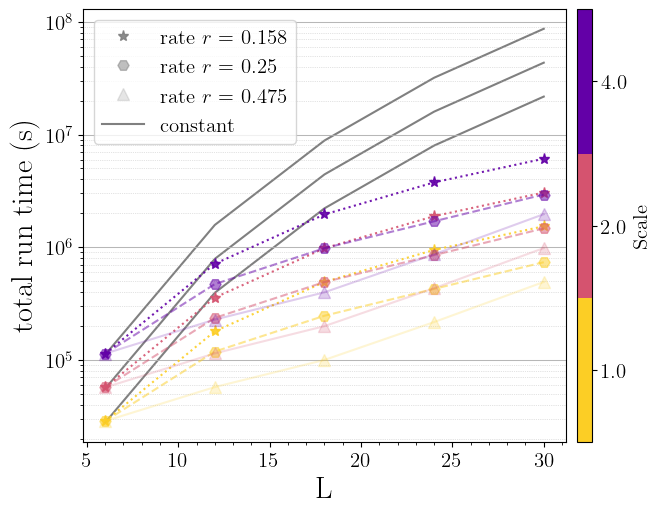

In [26]:
fig, ax = plt.subplots(figsize=square_fig_size)
ms = 'Triangular'

for scale_i,scale in enumerate(scales):
    for rate in rates[:]:
        if (scale==8.0) & (rate==0.158):
            continue
        decay = np.array([exp_decay_imported(l,scale=scale,rate=rate) for l in plot_ls_np])
        decay_runtimes = []
        num_steps_prev = 0
        amt_run_time_prev = 0
        for l_i,l in enumerate(plot_ls_np):
            num_new_steps = decay[l_i] 
            new_run_time = num_new_steps * plot_times[l_i]
            decay_runtimes.append(amt_run_time_prev + new_run_time)
            num_steps_prev += num_new_steps
            amt_run_time_prev += new_run_time
            if l==32:
                print(f"Estimated run time for {scale},{rate} = {new_run_time/(60*60*4)} hrs on 4 GPUs")

        plt.plot(plot_ls_np,decay_runtimes,color=scale_shades[ms][scale],
                 alpha=rate_alphas[rate],markersize=8,
                 marker=rate_markers[rate],linestyle=rate_lines[rate],
                label=f'rate={rate}, scale={scale}',)
        
    no_decay_scale = 100000 * scale
    no_decay_scale_runtimes = []
    num_steps_prev = 0
    amt_run_time_prev = 0
    for l_i,l in enumerate(plot_ls_np):
        num_new_steps =no_decay_scale
        new_run_time = num_new_steps * plot_times[l_i]
        no_decay_scale_runtimes.append(amt_run_time_prev + new_run_time)
        num_steps_prev += num_new_steps
        amt_run_time_prev += new_run_time

    plt.plot(plot_ls_np,no_decay_scale_runtimes,color='grey',label=f'constant,scale={scale}',zorder=-1)
    
add_gridlines(axes='y')
add_energy_legends(show_runs=True,show_const=True)

plt.yscale('log')
plt.ylabel("total run time (s)",fontsize=bigger_font_size)
plt.xlabel("L",fontsize=bigger_font_size)

plt.savefig('./final_figures/run_times.pdf',bbox_inches='tight',pad_inches=0.1)
plt.show()